In [1]:
# %% [markdown]
# 3Commodity Futures Pricing with Gibson–Schwartz and Schwartz–Smith (Calibrated)

# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    import yfinance as yf
except ImportError:
    yf = None

plt.style.use("default")
np.random.seed(42)


In [2]:
# %%
def get_commodity_prices(choice, start="2015-01-01"):
    """
    Download historical futures prices for the chosen commodity from Yahoo Finance.
    choice: 'oil', 'gold', 'copper', or 'natural_gas'
    returns: (prices Series, ticker)
    """
    if yf is None:
        raise ImportError("yfinance is required. Please install it with `pip install yfinance`.")

    choice = choice.strip().lower()

    # Map user input to correct Yahoo Finance futures tickers
    if choice == "oil":
        ticker = "CL=F"       # WTI crude oil futures
    elif choice == "gold":
        ticker = "GC=F"       # COMEX gold futures
    elif choice == "copper":
        ticker = "HG=F"       # COMEX copper futures
    elif choice in ["natural_gas", "natgas", "gas"]:
        ticker = "NG=F"       # NYMEX natural gas futures
    else:
        raise ValueError("choice must be 'oil', 'gold', 'copper', or 'natural_gas'.")

    # Download the historical data
    data = yf.download(ticker, start=start)

    # Futures sometimes lack Adj Close → fallback to Close
    if "Adj Close" in data.columns:
        prices = data["Adj Close"].dropna()
    else:
        prices = data["Close"].dropna()

    return prices, ticker



In [3]:
# %%
def calibrate_gbm(prices, dt=1/252):
    """
    Simple GBM calibration from log-returns.
    Returns mu_hat, sigma_hat (annualised).
    """
    logS = np.log(prices)
    rets = logS.diff().dropna()
    m = rets.mean()
    v = rets.var()
    sigma_hat = np.sqrt(v / dt)
    mu_hat = m / dt + 0.5 * sigma_hat**2
    return float(mu_hat), float(sigma_hat)


In [4]:
# %%
def moving_average_decomposition(logS, window=60):
    """
    Decompose log S_t into:
        log S_t = x_t + chi_t
    where x_t is a slow moving trend (rolling mean)
    and chi_t is the deviation.
    """
    x = logS.rolling(window=window, min_periods=window).mean().dropna()
    chi = logS.loc[x.index] - x
    return x, chi


def calibrate_ou_from_ar1(series, dt):
    """
    Calibrate continuous-time OU process from discrete AR(1):
        s_{t+1} = a + b s_t + eps_t
    Then:
        kappa = -ln(b)/dt
        theta = a / (1 - b)
        sigma from innovation variance.
    Returns:
        kappa, theta, sigma, eps (innovations), index_of_lagged_points
    """
    s = series.dropna()
    s_lag = s.shift(1).dropna()
    s_now = s.loc[s_lag.index]

    x = s_lag.values
    y = s_now.values

    x_mean = x.mean()
    y_mean = y.mean()
    b = np.sum((x - x_mean) * (y - y_mean)) / np.sum((x - x_mean) ** 2)
    a = y_mean - b * x_mean

    # Innovations
    eps = y - (a + b * x)
    var_eps = np.var(eps, ddof=1)

    # AR(1) → OU
    if b <= 0 or b >= 1:
        kappa = max(1e-6, -np.log(max(b, 1e-6)) / dt)
    else:
        kappa = -np.log(b) / dt

    theta = a / (1 - b) if abs(1 - b) > 1e-8 else 0.0

    denom = 1 - np.exp(-2 * kappa * dt)
    if denom <= 0:
        sigma = np.sqrt(max(var_eps, 0.0))
    else:
        sigma = np.sqrt(var_eps * 2 * kappa / denom)

    return float(kappa), float(theta), float(sigma), eps, s_lag.index


In [5]:
# %%
def calibrate_schwartz_smith(prices, dt=1/252, window=60):
    """
    Calibrate Schwartz–Smith two-factor model from spot prices.

    Steps:
      1) log S_t = x_t + chi_t  (trend + deviation)
      2) x_t: random walk with drift (mu_x, sigma_x)
      3) chi_t: OU via AR(1) (kappa, sigma_chi)
      4) correlation rho between shocks of x and chi
    """
    logS = np.log(prices)

    # 1) Decompose into long- and short-term factors
    x, chi = moving_average_decomposition(logS, window=window)
    x = x.dropna()
    chi = chi.loc[x.index]

    # 2) Long-term factor x_t: random walk with drift
    dx = x.diff().dropna()
    mu_x = dx.mean() / dt
    sigma_x = np.sqrt(dx.var() / dt)
    eps_x = dx - dx.mean()  # shocks in x

    # 3) Short-term factor chi_t: OU via AR(1)
    kappa_chi, theta_chi, sigma_chi, eps_chi, idx_chi_lag = calibrate_ou_from_ar1(chi, dt)

    # 4) Correlation between shocks of x and chi
    eps_x_aligned = eps_x.loc[idx_chi_lag].values
    eps_chi_aligned = eps_chi
    if len(eps_x_aligned) > 1:
        rho = np.corrcoef(eps_x_aligned, eps_chi_aligned)[0, 1]
    else:
        rho = 0.0

    # --- SAFETY: avoid NaNs / impossible values ---
    if not np.isfinite(rho):
        rho = 0.0
    rho = float(np.clip(rho, -0.95, 0.95))


    # Initial factors at last date
    x0 = float(x.iloc[-1])
    chi0 = float(chi.iloc[-1])

    params = {
        "x0": x0,
        "chi0": chi0,
        "mu_x": float(mu_x),
        "kappa": float(kappa_chi),
        "sigma_x": float(sigma_x),
        "sigma_chi": float(sigma_chi),
        "rho": rho,
    }
    return params


In [6]:
# %%
def calibrate_gibson_schwartz(prices, r=0.03, dt=1/252):
    """
    Calibrate Gibson–Schwartz approximately:

      dS_t = (r - delta_t) S_t dt + sigma_S S_t dW^S
      ddelta_t = kappa (alpha - delta_t) dt + sigma_delta dW^delta
    """
    logS = np.log(prices)
    rets = logS.diff().dropna()

    # 1) sigma_S from variance (annualised)
    v = rets.var()
    sigma_S = np.sqrt(v / dt)

    # 2) Approximate convenience yield sequence
    delta_t = r - rets / dt - 0.5 * sigma_S**2
    delta_t = delta_t.dropna()

    # 3) OU calibration on delta_t
    kappa, alpha, sigma_delta, eps_delta, idx_delta_lag = calibrate_ou_from_ar1(delta_t, dt)

    rets_centered = rets - rets.mean()
    rets_aligned = rets_centered.loc[idx_delta_lag].values
    eps_delta_aligned = eps_delta
    if len(rets_aligned) > 1:
        rho = np.corrcoef(rets_aligned, eps_delta_aligned)[0, 1]
    else:
        rho = 0.0

    # --- SAFETY: avoid NaNs / impossible values for rho ---
    if not np.isfinite(rho):
        rho = 0.0
    rho = float(np.clip(rho, -0.95, 0.95))

    # --- SAFETY: tame extreme parameter values (Patch 2) ---
    kappa = float(np.clip(kappa, 0.01, 20.0))
    sigma_delta = float(np.clip(sigma_delta, 1e-6, 5.0))
    sigma_S = float(np.clip(sigma_S, 1e-6, 2.0))

    # initial convenience yield
    delta0 = float(delta_t.iloc[-1])

    params = {
        "delta0": delta0,
        "kappa": float(kappa),
        "alpha": float(alpha),
        "sigma_S": float(sigma_S),
        "sigma_delta": float(sigma_delta),
        "rho": rho,
    }
    return params



In [7]:
def generate_correlated_normals(n_paths, n_steps, rho, random_state=None):
    # safety
    if not np.isfinite(rho):
        rho = 0.0
    rho = float(np.clip(rho, -0.95, 0.95))

    rng = np.random.default_rng(random_state)
    Z1 = rng.normal(size=(n_paths, n_steps))
    Z2 = rng.normal(size=(n_paths, n_steps))
    Z2_corr = rho * Z1 + np.sqrt(1 - rho**2) * Z2
    return Z1, Z2_corr



In [8]:
# %%
def simulate_gibson_schwartz(
    S0,
    delta0,
    r,
    kappa,
    alpha,
    sigma_S,
    sigma_delta,
    rho,
    T,
    n_steps,
    n_paths,
    random_state=None
):
    """
    Gibson–Schwartz under Q:
        dS_t = (r - delta_t) S_t dt + sigma_S S_t dW^S
        ddelta_t = kappa (alpha - delta_t) dt + sigma_delta dW^delta
    """
    dt = T / n_steps
    t_grid = np.linspace(0, T, n_steps + 1)

    S_paths = np.zeros((n_paths, n_steps + 1))
    delta_paths = np.zeros((n_paths, n_steps + 1))

    S_paths[:, 0] = S0
    delta_paths[:, 0] = delta0

    Z1, Z2_corr = generate_correlated_normals(n_paths, n_steps, rho, random_state=random_state)

    for i in range(n_steps):
        S_t = S_paths[:, i]
        delta_t = delta_paths[:, i]

        dW_S = np.sqrt(dt) * Z1[:, i]
        dW_delta = np.sqrt(dt) * Z2_corr[:, i]

        # OU for convenience yield
        delta_next = delta_t + kappa * (alpha - delta_t) * dt + sigma_delta * dW_delta

        # Log-Euler for S
        log_S_next = np.log(S_t) + (r - delta_t - 0.5 * sigma_S**2) * dt + sigma_S * dW_S
        S_next = np.exp(log_S_next)

        S_paths[:, i + 1] = S_next
        delta_paths[:, i + 1] = delta_next

    return t_grid, S_paths, delta_paths


In [9]:
# %%
def simulate_schwartz_smith(
    S0,
    x0,
    chi0,
    mu_x,
    kappa,
    sigma_x,
    sigma_chi,
    rho,
    T,
    n_steps,
    n_paths,
    random_state=None
):
    """
    Schwartz–Smith two-factor model:
        dx_t   = mu_x dt + sigma_x dW^x
        dchi_t = -kappa chi_t dt + sigma_chi dW^chi
        ln S_t = x_t + chi_t
    """
    dt = T / n_steps
    t_grid = np.linspace(0, T, n_steps + 1)

    x_paths = np.zeros((n_paths, n_steps + 1))
    chi_paths = np.zeros((n_paths, n_steps + 1))
    S_paths = np.zeros((n_paths, n_steps + 1))

    x_paths[:, 0] = x0
    chi_paths[:, 0] = chi0
    S_paths[:, 0] = S0

    Z1, Z2_corr = generate_correlated_normals(n_paths, n_steps, rho, random_state=random_state)

    for i in range(n_steps):
        x_t = x_paths[:, i]
        chi_t = chi_paths[:, i]

        dW_x = np.sqrt(dt) * Z1[:, i]
        dW_chi = np.sqrt(dt) * Z2_corr[:, i]

        x_next = x_t + mu_x * dt + sigma_x * dW_x
        chi_next = chi_t - kappa * chi_t * dt + sigma_chi * dW_chi

        S_next = np.exp(x_next + chi_next)

        x_paths[:, i + 1] = x_next
        chi_paths[:, i + 1] = chi_next
        S_paths[:, i + 1] = S_next

    return t_grid, S_paths, x_paths, chi_paths


In [10]:
# %%
def futures_price_from_paths(S_paths, maturity_index):
    """
    Approximate futures price F(0,T) = E_Q[S_T] from simulated paths.
    """
    S_T = S_paths[:, maturity_index]
    return float(np.mean(S_T))


def price_european_call_mc(S_paths, r, T, K, maturity_index):
    """
    Price a European call option on the spot via Monte Carlo.
    """
    S_T = S_paths[:, maturity_index]
    payoff = np.maximum(S_T - K, 0.0)
    discounted = np.exp(-r * T) * payoff
    return float(np.mean(discounted))


Choose commodity (oil/gold/copper/natural_gas): gold


/tmp/ipython-input-3891477690.py:26: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-565641190.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S0 = float(prices.iloc[-1])



Using GOLD with ticker GC=F
Last observed spot (proxy): 4223.90
Number of observations: 2751


<Figure size 640x480 with 0 Axes>

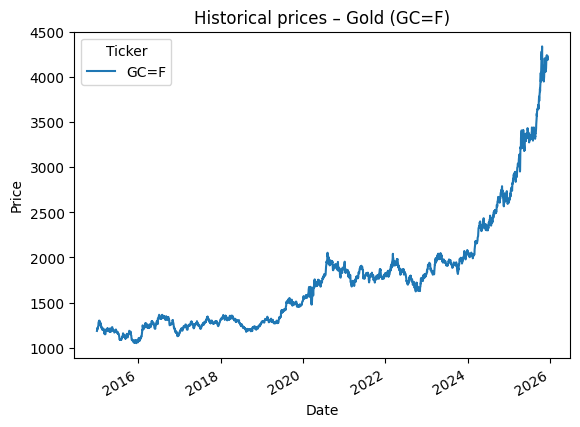

/tmp/ipython-input-3398547391.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(mu_hat), float(sigma_hat)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)



GBM calibration (real-world):
  mu    = 0.1280
  sigma = 0.1526


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/tmp/ipython-input-564374482.py:39: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigma_S = float(np.clip(sigma_S, 1e-6, 2.0))
/tmp/ipython-input-564374482.py:42: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  delta0 = float(delta_t.iloc[-1])
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_im


Gibson–Schwartz calibrated parameters:
  delta0       = -1.0099
  kappa        = 20.0000
  alpha        = -0.0967
  sigma_S      = 0.1526
  sigma_delta  = 5.0000
  rho          = 0.0000

Schwartz–Smith calibrated parameters:
  x0           = 8.3001
  chi0         = 0.0484
  mu_x         = 0.1120
  kappa        = 7.6516
  sigma_x      = 0.0183
  sigma_chi    = 0.1525
  rho          = 0.0000


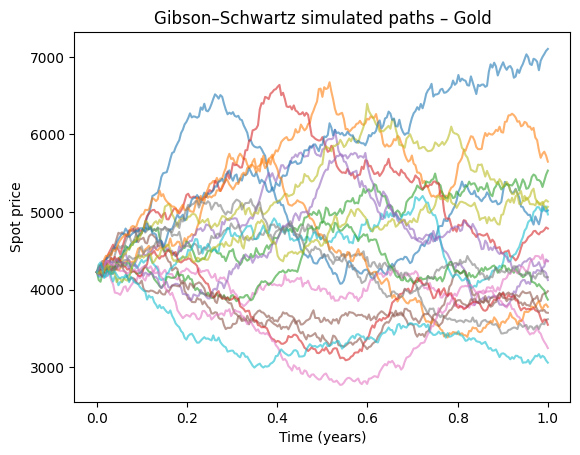

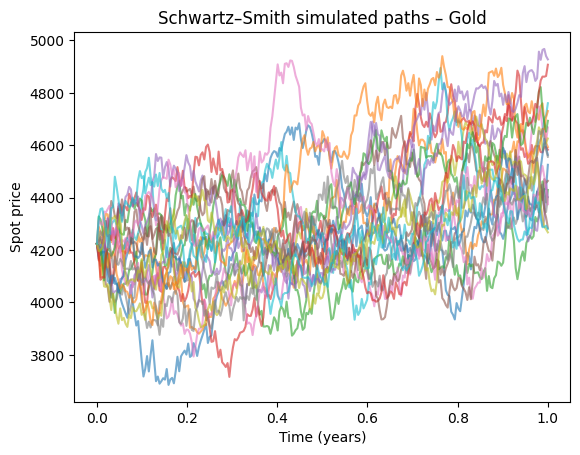

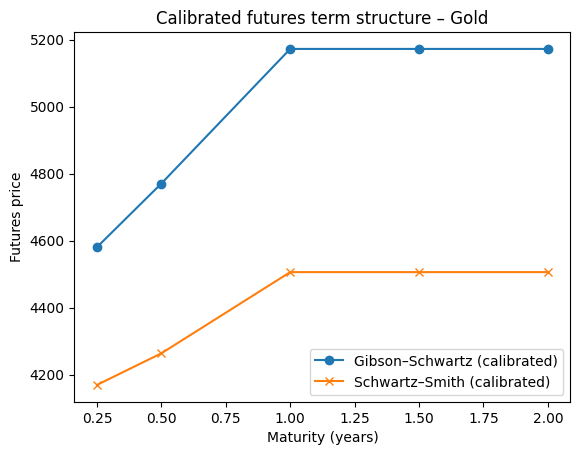


European call option on spot (Monte Carlo):
  Strike K = 4223.90, maturity T = 1.0 years
  Gibson–Schwartz price (calibrated):  1103.9097
  Schwartz–Smith price  (calibrated):  279.2830


In [11]:
# %%
# === USER INPUTS ===
choice = input("Choose commodity (oil/gold/copper/natural_gas): ")
r = 0.03        # risk-free rate (assumed)
T = 1.0         # horizon for simulation in years
n_steps = 252   # time steps
n_paths = 5000  # Monte Carlo paths
random_state = 42
dt = 1/252

# === DOWNLOAD DATA ===
prices, ticker = get_commodity_prices(choice, start="2015-01-01")
S0 = float(prices.iloc[-1])

print(f"\nUsing {choice.upper()} with ticker {ticker}")
print(f"Last observed spot (proxy): {S0:.2f}")
print(f"Number of observations: {len(prices)}")

plt.figure()
prices.plot()
plt.title(f"Historical prices – {choice.capitalize()} ({ticker})")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

# === CALIBRATION ===
mu_gbm, sigma_gbm = calibrate_gbm(prices, dt=dt)
print(f"\nGBM calibration (real-world):")
print(f"  mu    = {mu_gbm:.4f}")
print(f"  sigma = {sigma_gbm:.4f}")

gs_params = calibrate_gibson_schwartz(prices, r=r, dt=dt)
ss_params = calibrate_schwartz_smith(prices, dt=dt, window=60)

print("\nGibson–Schwartz calibrated parameters:")
for k, v in gs_params.items():
    print(f"  {k:12s} = {v:.4f}")

print("\nSchwartz–Smith calibrated parameters:")
for k, v in ss_params.items():
    print(f"  {k:12s} = {v:.4f}")

# === SIMULATE PATHS ===
t_gs, S_gs, delta_gs = simulate_gibson_schwartz(
    S0=S0,
    delta0=gs_params["delta0"],
    r=r,
    kappa=gs_params["kappa"],
    alpha=gs_params["alpha"],
    sigma_S=gs_params["sigma_S"],
    sigma_delta=gs_params["sigma_delta"],
    rho=gs_params["rho"],
    T=T,
    n_steps=n_steps,
    n_paths=n_paths,
    random_state=random_state,
)

t_ss, S_ss, x_ss, chi_ss = simulate_schwartz_smith(
    S0=S0,
    x0=ss_params["x0"],
    chi0=ss_params["chi0"],
    mu_x=ss_params["mu_x"],
    kappa=ss_params["kappa"],
    sigma_x=ss_params["sigma_x"],
    sigma_chi=ss_params["sigma_chi"],
    rho=ss_params["rho"],
    T=T,
    n_steps=n_steps,
    n_paths=n_paths,
    random_state=random_state,
)

# === PLOT SAMPLE PATHS ===
plt.figure()
for i in range(20):
    plt.plot(t_gs, S_gs[i, :], alpha=0.6)
plt.title(f"Gibson–Schwartz simulated paths – {choice.capitalize()}")
plt.xlabel("Time (years)")
plt.ylabel("Spot price")
plt.show()

plt.figure()
for i in range(20):
    plt.plot(t_ss, S_ss[i, :], alpha=0.6)
plt.title(f"Schwartz–Smith simulated paths – {choice.capitalize()}")
plt.xlabel("Time (years)")
plt.ylabel("Spot price")
plt.show()

# === FUTURES TERM STRUCTURE ===
maturities = np.array([0.25, 0.5, 1.0, 1.5, 2.0])

F_gs = []
F_ss = []
for T_mat in maturities:
    idx_gs = int(np.argmin(np.abs(t_gs - T_mat)))
    idx_ss = int(np.argmin(np.abs(t_ss - T_mat)))
    F_gs.append(futures_price_from_paths(S_gs, idx_gs))
    F_ss.append(futures_price_from_paths(S_ss, idx_ss))

F_gs = np.array(F_gs)
F_ss = np.array(F_ss)

plt.figure()
plt.plot(maturities, F_gs, marker="o", label="Gibson–Schwartz (calibrated)")
plt.plot(maturities, F_ss, marker="x", label="Schwartz–Smith (calibrated)")
plt.xlabel("Maturity (years)")
plt.ylabel("Futures price")
plt.title(f"Calibrated futures term structure – {choice.capitalize()}")
plt.legend()
plt.show()

# === EXAMPLE: EUROPEAN CALL OPTION PRICING ===
T_opt = 1.0
K = S0  # at-the-money strike
idx_opt_gs = int(np.argmin(np.abs(t_gs - T_opt)))
idx_opt_ss = int(np.argmin(np.abs(t_ss - T_opt)))

call_price_gs = price_european_call_mc(S_gs, r, T_opt, K, idx_opt_gs)
call_price_ss = price_european_call_mc(S_ss, r, T_opt, K, idx_opt_ss)

print("\nEuropean call option on spot (Monte Carlo):")
print(f"  Strike K = {K:.2f}, maturity T = {T_opt} years")
print(f"  Gibson–Schwartz price (calibrated):  {call_price_gs:.4f}")
print(f"  Schwartz–Smith price  (calibrated):  {call_price_ss:.4f}")
